In [403]:
import pandas as pd
import os, collections, csv, random
import numpy as np
from sympy import Point3D, Line3D
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [416]:
cluster_list = {
    'RSK':['RSK1', 'RSK2', 'RSK3', 'RSK4'],
    'LSK':['LSK1', 'LSK2', 'LSK3', 'LSK4'],
    'RTH':['RTH1', 'RTH2', 'RTH3', 'RTH4'],
    'LTH':['LTH1', 'LTH2', 'LTH3', 'LTH4'],
    'RFT':['RF1', 'RF2', 'RF3'],
    'LFT':['LF1', 'LF2', 'LF3'],
    'RUA':['RUA1', 'RUA2', 'RUA3', 'RUA4'],
    'LUA':['LUA1', 'LUA2', 'LUA3', 'LUA4'],
    'RFA':['RFA1', 'RFA2', 'RFA3'],
    'LFA':['LFA1', 'LFA2', 'LFA3'],
    'TS':['SPN1', 'SPN2', 'SPN3'],
    'SAC':['PVLS1', 'PVLS2', 'PVLS3']
}

In [417]:
marker_list = {
    'RSK':['RFAL', 'RTAM'],
    'LSK':['LFAL', 'LTAM'],
    ########knee##############
    'RTH':['RFLE', 'RFME'],
    'LTH':['LFLE', 'LFME'],
    ###########Foot##############
    'RFT':['RFMT1', 'RFMT2', 'RFMT5'],
    'LFT':['LFMT1', 'LFMT2', 'LFMT5'],
    #########elbow###########
    'RUA':['RHME', 'RHLE'],
    'LUA':['LHME', 'LHLE'],
    #wrist####
    'RFA':['RUSP', 'RRSP'],
    'LFA':['LUSP', 'LRSP'],
    ############hand########
    'LHMC':['LCAP'],
    'RHMC':['RCAP'],
    ####T spine####### 
    'TS':['T4', 'T8', 'T10', 'STER', 'XPRO'],
    #########pelvis############
    'SAC':['RASIS', 'RPSIS', 'LASIS', 'LPSIS']
    }

In [418]:
def manipulate_data(file_dir):
    with open(file_dir) as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter="\t")
        event_list = []

        # calculate the number of rows to skip to get to markers data
        number_of_rows_to_skip = -1

        # record all event first before skipping these lines
        for line in tsvreader:
            # once found data, stop collecting event and break the loop
            if line[0] == "MARKER_NAMES":
                break
            number_of_rows_to_skip += 1

        df = pd.read_csv(tsvfile, delimiter="\t")
        # remove unamed column
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    return df

In [419]:
def unit_vector(vector):
    dist = np.sqrt(sum(vector**2))
    return (vector/dist)

In [420]:
def dist(data1, data2):
    df = pd.DataFrame(columns=['markers', 'distance'])
    missing_marker = []
    for cluster, anatomical_list in marker_list.items():
        try:
            target_cluster1 = np.array(np.mean(data1.loc[:, data1.columns[(data1.columns.str.contains('|'.join(cluster_list[cluster])))]])).reshape(-1,3)
            Xaxis1 = unit_vector(target_cluster1[1] - target_cluster1[0])
            Zaxis1 = unit_vector(np.cross(Xaxis1, unit_vector(target_cluster1[2] - target_cluster1[1])))
            Yaxis1 = unit_vector(np.cross(Xaxis1, Zaxis1))
            trans_matrix1 = np.array([Xaxis1, Yaxis1, Zaxis1, target_cluster1[0]])
            trans_matrix1 = np.concatenate([trans_matrix1, np.array([0, 0, 0, 1]).reshape(4,1)], axis = 1).T
            i_trans_matrix1 = np.linalg.inv(trans_matrix1)
            
            target_cluster2 = np.array(np.mean(data2.loc[:, data2.columns[(data2.columns.str.contains('|'.join(cluster_list[cluster])))]])).reshape(-1,3)
            Xaxis2 = unit_vector(target_cluster2[1] - target_cluster2[0])
            Zaxis2 = unit_vector(np.cross(Xaxis2, unit_vector(target_cluster2[2] - target_cluster2[1])))
            Yaxis2 = unit_vector(np.cross(Xaxis2, Zaxis2))
            trans_matrix2 = np.array([Xaxis2, Yaxis2, Zaxis2, target_cluster2[0]])
            trans_matrix2 = np.concatenate([trans_matrix2, np.array([0, 0, 0, 1]).reshape(4,1)], axis = 1).T
            i_trans_matrix2 = np.linalg.inv(trans_matrix2)


            for anatomical in anatomical_list:
                try:
                    target_anatomical1 = np.array(np.mean(data1.loc[:, data1.columns[(data1.columns.str.contains(anatomical))]]))
                    target_anatomical1 = np.concatenate([target_anatomical1, np.array([1])], axis = 0)
                    target_anatomical2 = np.array(np.mean(data2.loc[:, data2.columns[(data2.columns.str.contains(anatomical))]]))
                    target_anatomical2 = np.concatenate([target_anatomical2, np.array([1])], axis = 0)

                    # target_anatomical2 = np.array(np.mean(data2.loc[:, data2.columns[(data2.columns.str.contains(anatomical))]])).reshape(-1,3)
                    tester1 = np.matmul(i_trans_matrix1, target_anatomical1)
                    tester2 = np.matmul(i_trans_matrix2, target_anatomical2)

                    d_matrix = tester1 - tester2
                    dist = np.sqrt(sum(d_matrix**2))
                    new_row = {'markers': anatomical, 'distance': dist}
                    df = df.append(new_row, ignore_index = True)
                except:
                    missing_marker.append(anatomical)
        except:
            missing_marker.append(cluster)
    df = df.sort_values(by = ['distance'], ascending=False)

    return df


In [421]:
def plot_graph(df):
    # figure(figsize = (8,6), dpi = 100)
    fig, ax = plt.subplots()
    markers = df["markers"]
    y_pos = df["distance"]

    ax.barh(markers, y_pos)
    for i, v in enumerate(y_pos):
        ax.text(v, i, str(round(v,2)))
        
    # ax.set_yticks(y_pos, labels=markers)
    # ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Distance(mm)')
    ax.set_title('MPP Reliability')

    plt.grid()
    plt.show()

In [422]:
test1 = manipulate_data(r"Z:\DataCollection\AbilityData\Reliability\MPP\betweenGoldStandards\test\Isaac_0001_static_01.tsv")
test2 = manipulate_data(r"Z:\DataCollection\AbilityData\Reliability\MPP\betweenGoldStandards\test\Baratha_0001_static_01.tsv")


In [423]:
test_df = dist(test1, test2)

c:\Users\Administrator\anaconda3\envs\reliabilityMPP\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3212\2183669987.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
c:\Users\Administrator\anaconda3\envs\reliabilityMPP\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Administrator\AppData\Local\Temp\i

In [424]:
isaac1 = manipulate_data(r"Z:\DataCollection\AbilityData\Reliability\MPP\betweenGoldStandards\ISAAC_0001.tsv")
isaac3 = manipulate_data(r"Z:\DataCollection\AbilityData\Reliability\MPP\betweenGoldStandards\ISAAC_0003.tsv")
oliver2 = manipulate_data(r"Z:\DataCollection\AbilityData\Reliability\MPP\betweenGoldStandards\OLIVER_0002.tsv")
oliver4 = manipulate_data(r"Z:\DataCollection\AbilityData\Reliability\MPP\betweenGoldStandards\OLIVER_0004.tsv")

In [425]:
df1 = dist(isaac1, oliver2)
df2 = dist(isaac3, oliver4)

c:\Users\Administrator\anaconda3\envs\reliabilityMPP\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3212\2183669987.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
c:\Users\Administrator\anaconda3\envs\reliabilityMPP\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Administrator\AppData\Local\Temp\i

In [426]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "figure.figsize": (20,20),
    "font.size": 20})

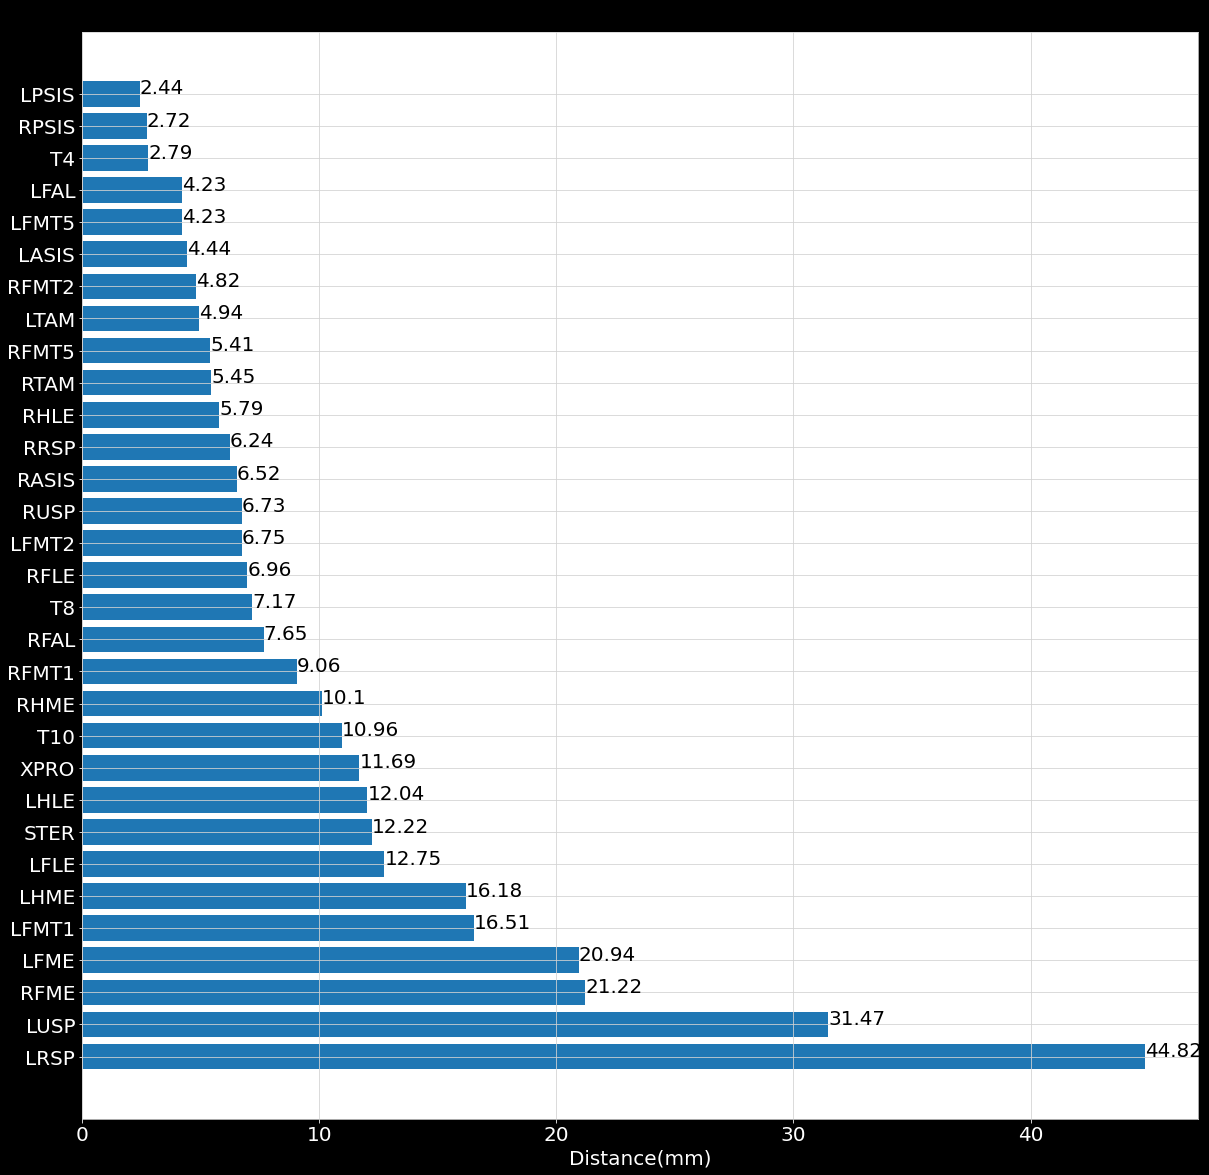

In [427]:
plot_graph(df1)

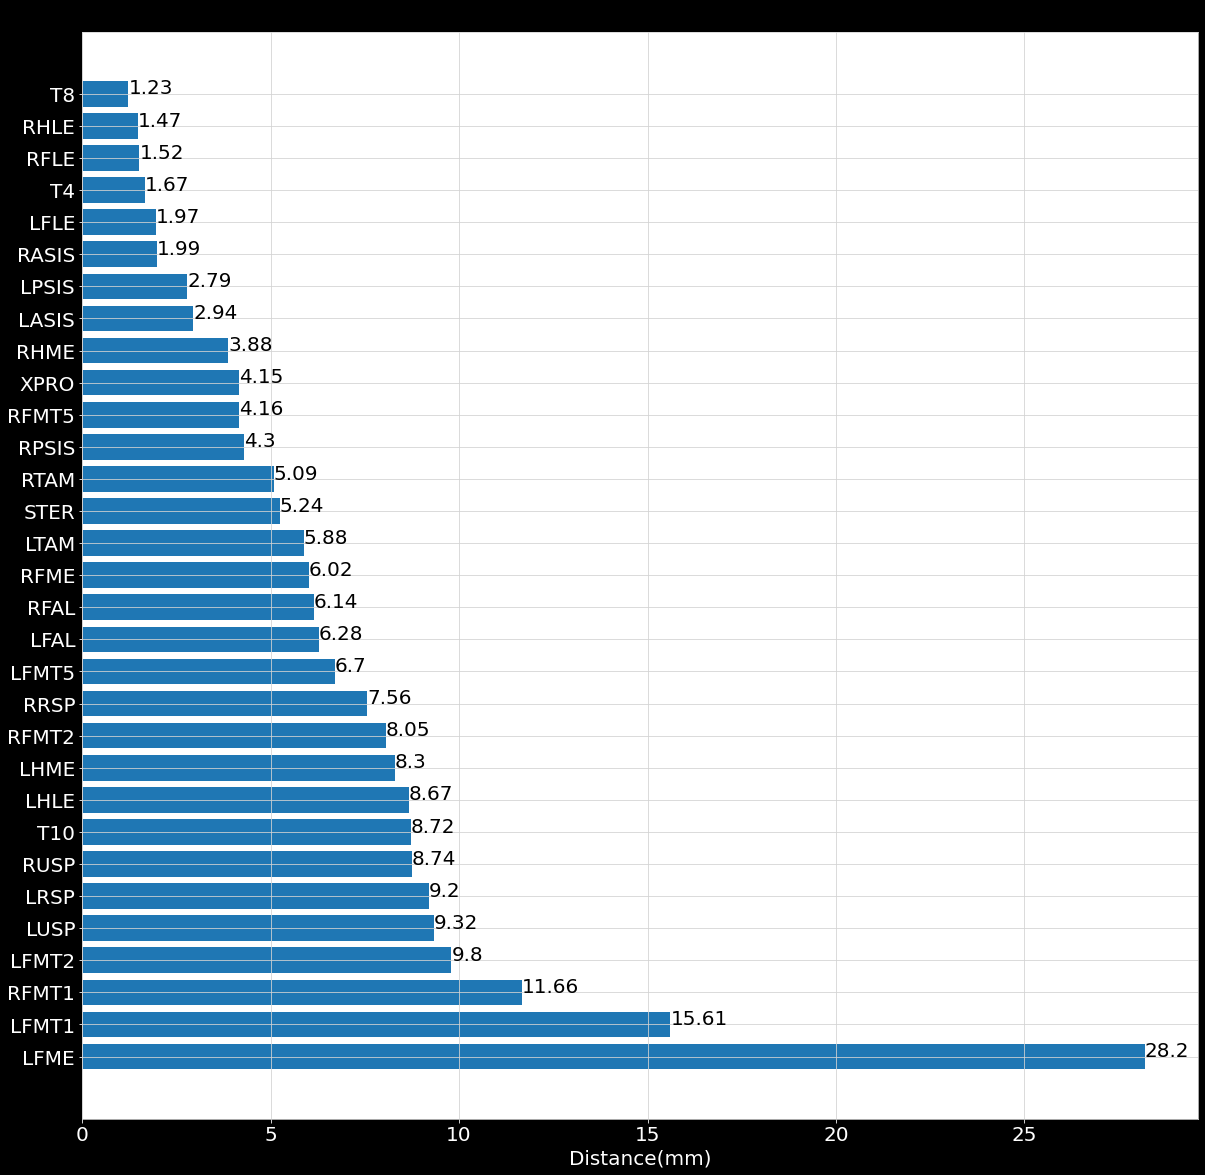

In [428]:
plot_graph(df2)

In [9]:
test = {"hello":4, "bye":7}

In [10]:
test[0]

KeyError: 0

In [12]:
list(test.values())

[4, 7]